***Import Needed Libs***

In [ ]:
import os
from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


***Preprocessing Train Dataset***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

train_data_path = '/content/drive/MyDrive/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
df

,filepaths,label
0,/content/drive/MyDrive/chest_xray/train/NORMAL...,NORMAL
1,/content/drive/MyDrive/chest_xray/train/NORMAL...,NORMAL
2,/content/drive/MyDrive/chest_xray/train/NORMAL...,NORMAL
3,/content/drive/MyDrive/chest_xray/train/NORMAL...,NORMAL
4,/content/drive/MyDrive/chest_xray/train/NORMAL...,NORMAL
...,...,...
5228,/content/drive/MyDrive/chest_xray/train/PNEUMO...,PNEUMONIA
5229,/content/drive/MyDrive/chest_xray/train/PNEUMO...,PNEUMONIA
5230,/content/drive/MyDrive/chest_xray/train/PNEUMO...,PNEUMONIA
5231,/content/drive/MyDrive/chest_xray/train/PNEUMO...,PNEUMONIA


***Preprocessing Valid Dataset***

In [ ]:
valid_data_dir = '/content/drive/MyDrive/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
valid

,filepaths,label
0,/content/drive/MyDrive/chest_xray/val/PNEUMONI...,PNEUMONIA
1,/content/drive/MyDrive/chest_xray/val/PNEUMONI...,PNEUMONIA
2,/content/drive/MyDrive/chest_xray/val/PNEUMONI...,PNEUMONIA
3,/content/drive/MyDrive/chest_xray/val/PNEUMONI...,PNEUMONIA
4,/content/drive/MyDrive/chest_xray/val/PNEUMONI...,PNEUMONIA
5,/content/drive/MyDrive/chest_xray/val/PNEUMONI...,PNEUMONIA
6,/content/drive/MyDrive/chest_xray/val/PNEUMONI...,PNEUMONIA
7,/content/drive/MyDrive/chest_xray/val/PNEUMONI...,PNEUMONIA
8,/content/drive/MyDrive/chest_xray/val/NORMAL/N...,NORMAL
9,/content/drive/MyDrive/chest_xray/val/NORMAL/N...,NORMAL


***Preprocessing Test Dataset***

In [ ]:
test_data_dir = '/content/drive/MyDrive/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
test

,filepaths,label
0,/content/drive/MyDrive/chest_xray/test/PNEUMON...,PNEUMONIA
1,/content/drive/MyDrive/chest_xray/test/PNEUMON...,PNEUMONIA
2,/content/drive/MyDrive/chest_xray/test/PNEUMON...,PNEUMONIA
3,/content/drive/MyDrive/chest_xray/test/PNEUMON...,PNEUMONIA
4,/content/drive/MyDrive/chest_xray/test/PNEUMON...,PNEUMONIA
...,...,...
287,/content/drive/MyDrive/chest_xray/test/PNEUMON...,PNEUMONIA
288,/content/drive/MyDrive/chest_xray/test/PNEUMON...,PNEUMONIA
289,/content/drive/MyDrive/chest_xray/test/PNEUMON...,PNEUMONIA
290,/content/drive/MyDrive/chest_xray/test/PNEUMON...,PNEUMONIA


***Spliting Data Into Train, Valid, Test***

In [ ]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

***ImageDataGenerator***

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4186 validated image filenames belonging to 2 classes.
Found 523 validated image filenames belonging to 2 classes.
Found 524 validated image filenames belonging to 2 classes.


***Showing Sample From Data***

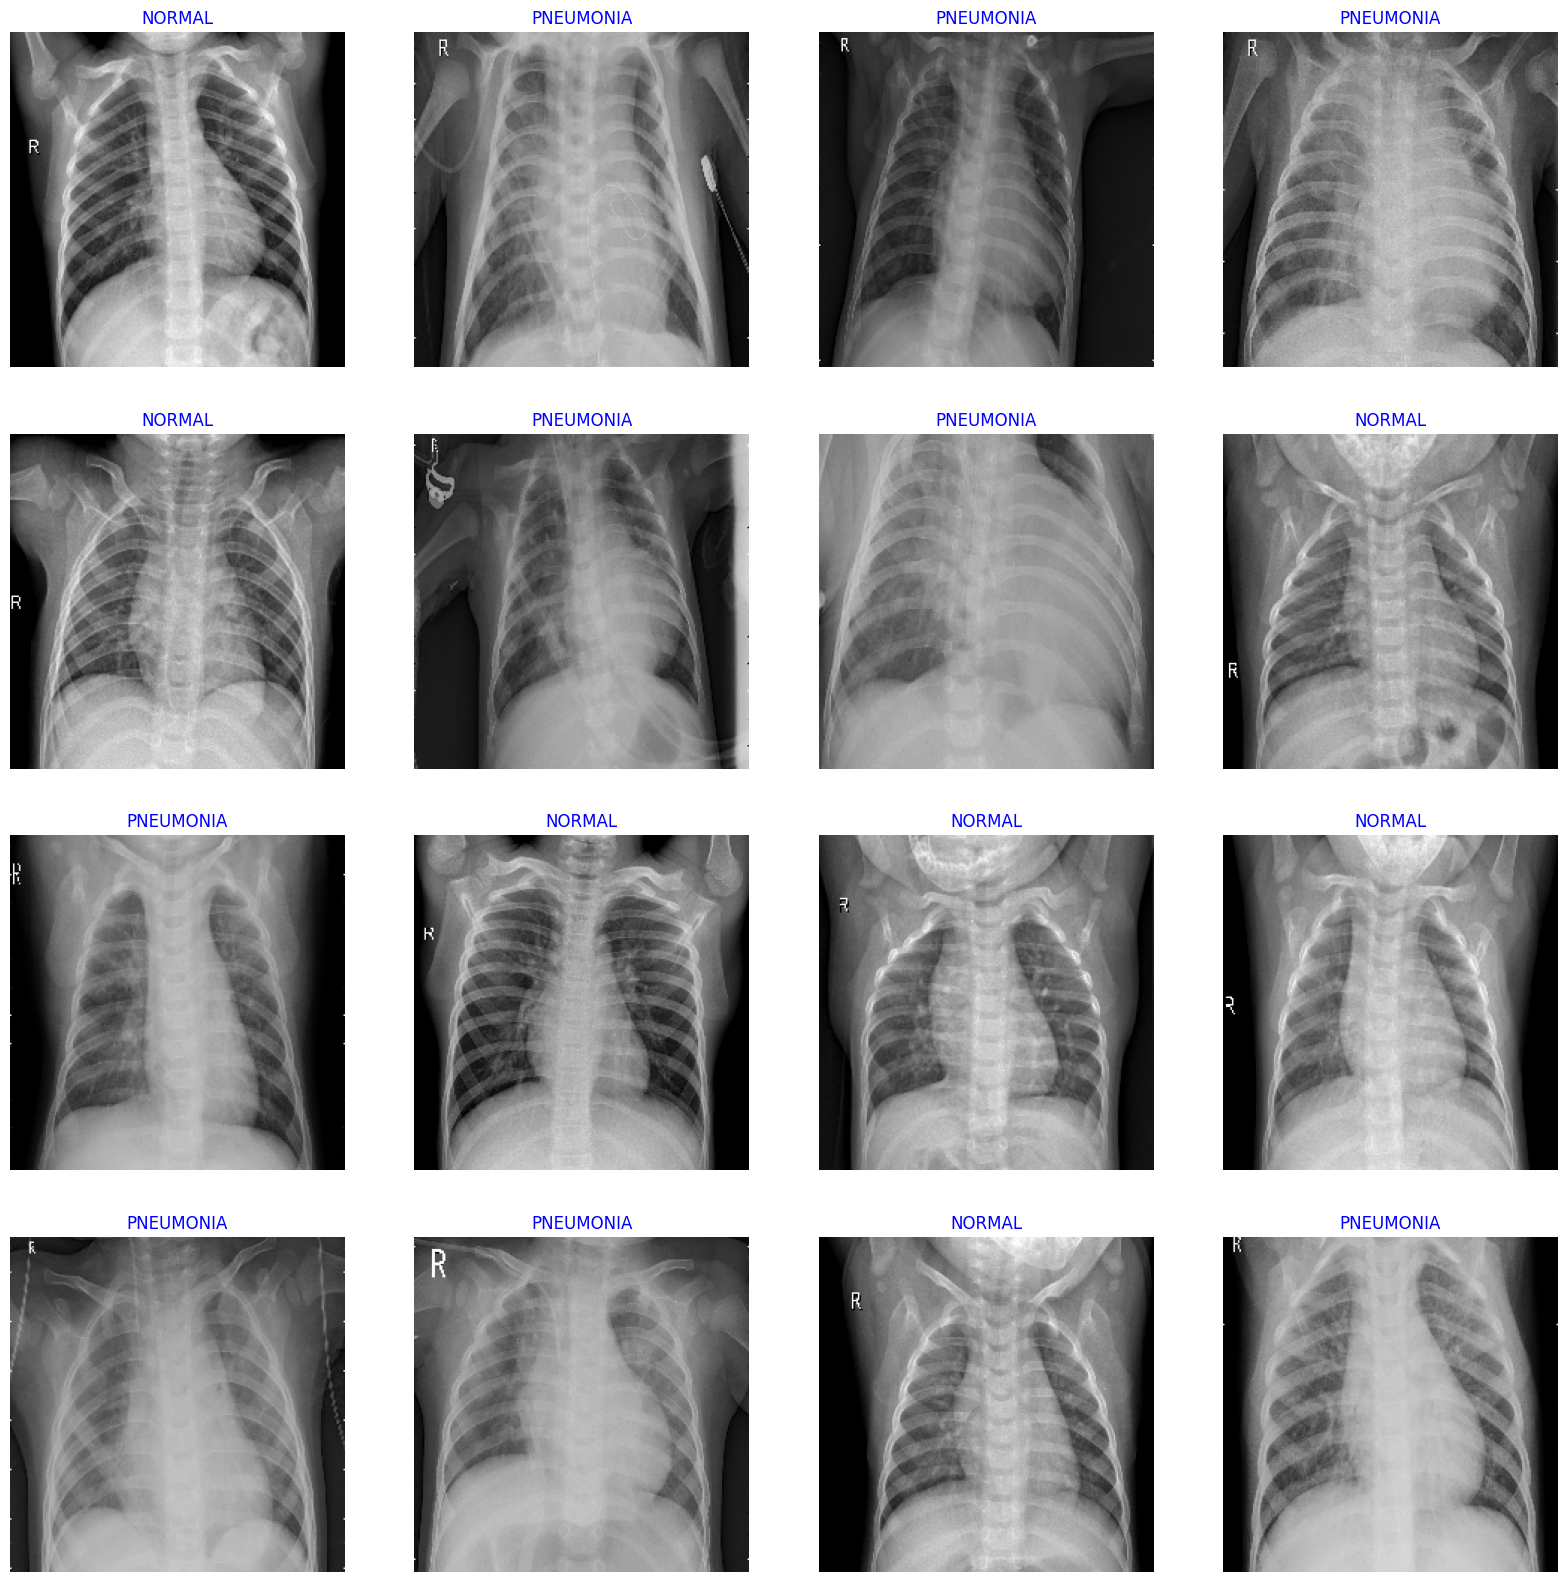

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

***Model***

MOBILENET

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

mobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers in the pre-trained MobileNet model
for i, layer in enumerate(mobileNet.layers):
    print(f"Layer {i+1}")
    layer.trainable = False

# Add your own classification layers on top of MobileNet
x = Flatten()(mobileNet.output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(class_count, activation='softmax')(x)

# Create a new model combining MobileNet and your classification layers
model = Model(inputs=mobileNet.input, outputs=output)

model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 15
Layer 16
Layer 17
Layer 18
Layer 19
Layer 20
Layer 21
Layer 22
Layer 23
Layer 24
Layer 25
Layer 26
Layer 27
Layer 28
Layer 29
Layer 30
Layer 31
Layer 32
Layer 33
Layer 34
Layer 35
Layer 36
Layer 37
Layer 38
Layer 39
Layer 40
Layer 41
Layer 42
Layer 43
Layer 44
Layer 45
Layer 46
Layer 47
Layer 48
Layer 49
Layer 50
Layer 51
Layer 52
Layer 53
Layer 54
Layer 55
Layer 56
Layer 57
Layer 58
Layer 59
Layer 60
Layer 61
Layer 62
Layer 63
Layer 64
Layer 65
Layer 66
Layer 67
Layer 68
Layer 69
Layer 70
Layer 71
Layer 72
Layer 73
Layer 74
Layer 75
Layer 76
Layer 77
Layer 78
Layer 79
Layer 80
Layer 81
Layer 82
Layer 83
Layer 84
Layer 85
Layer 86
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)  

### Training The Data

In [ ]:
epochs = 13   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/13
262/262 [==============================] - 1926s 7s/step - loss: 0.2149 - accuracy: 0.9250 - val_loss: 0.1013 - val_accuracy: 0.9598
Epoch 2/13
262/262 [==============================] - 62s 235ms/step - loss: 0.0758 - accuracy: 0.9723 - val_loss: 0.0840 - val_accuracy: 0.9713
Epoch 3/13
262/262 [==============================] - 59s 227ms/step - loss: 0.0422 - accuracy: 0.9866 - val_loss: 0.0830 - val_accuracy: 0.9675
Epoch 4/13
262/262 [==============================] - 58s 220ms/step - loss: 0.0292 - accuracy: 0.9909 - val_loss: 0.0636 - val_accuracy: 0.9771
Epoch 5/13
262/262 [==============================] - 58s 222ms/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.0754 - val_accuracy: 0.9694
Epoch 6/13
262/262 [==============================] - 64s 243ms/step - loss: 0.0146 - accuracy: 0.9967 - val_loss: 0.0827 - val_accuracy: 0.9732
Epoch 7/13
262/262 [==============================] - 59s 225ms/step - loss: 0.0078 - accuracy: 0.9995 - val_loss: 0.0839 - val_acc

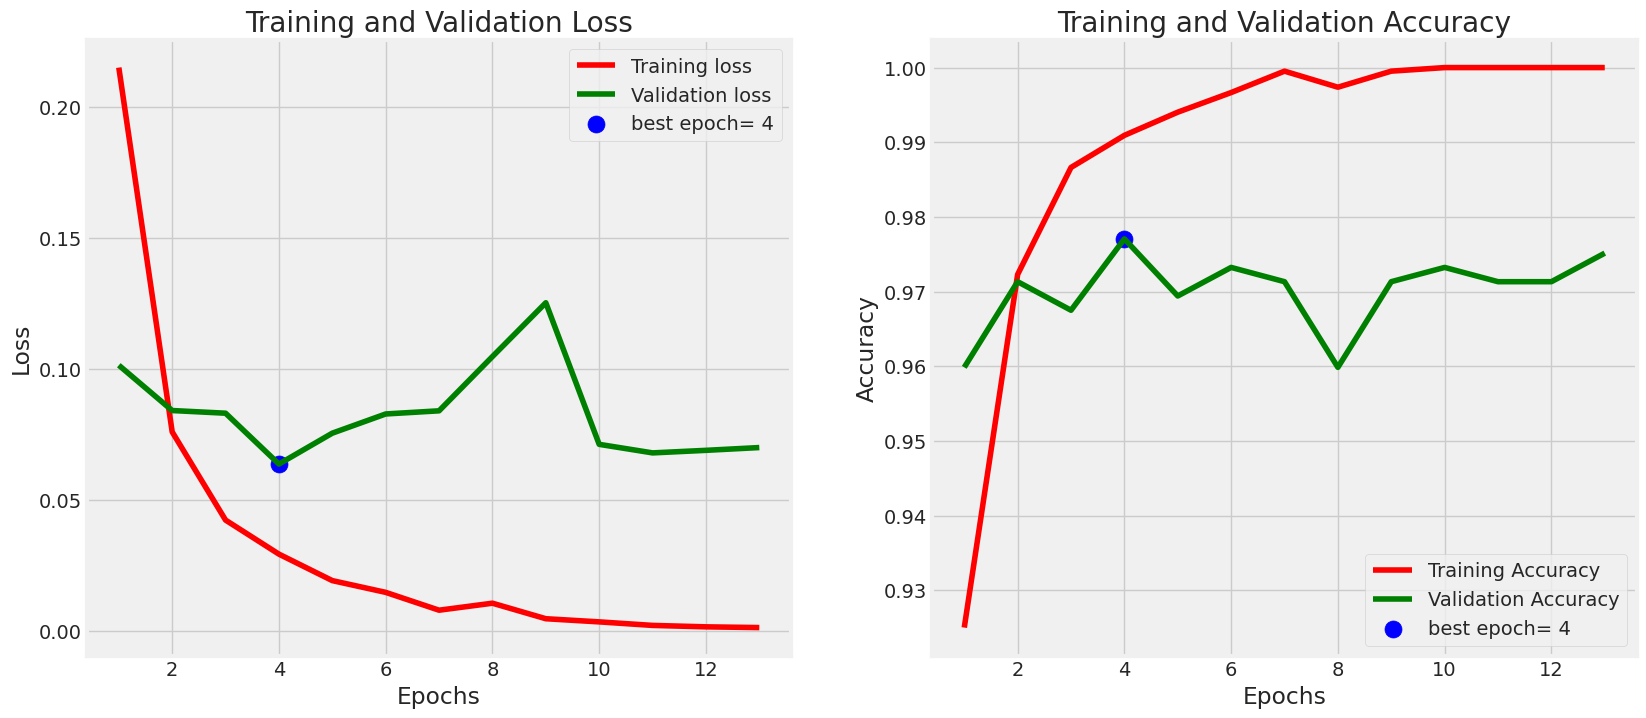

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

33/33 [==============================] - 213s 7s/step - loss: 0.0559 - accuracy: 0.9809
Train Loss:  0.0011285373475402594
Train Accuracy:  1.0
--------------------
Validation Loss:  0.06987842917442322
Validation Accuracy:  0.9751434326171875
--------------------
Test Loss:  0.05592985451221466
Test Accuracy:  0.9809160232543945


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

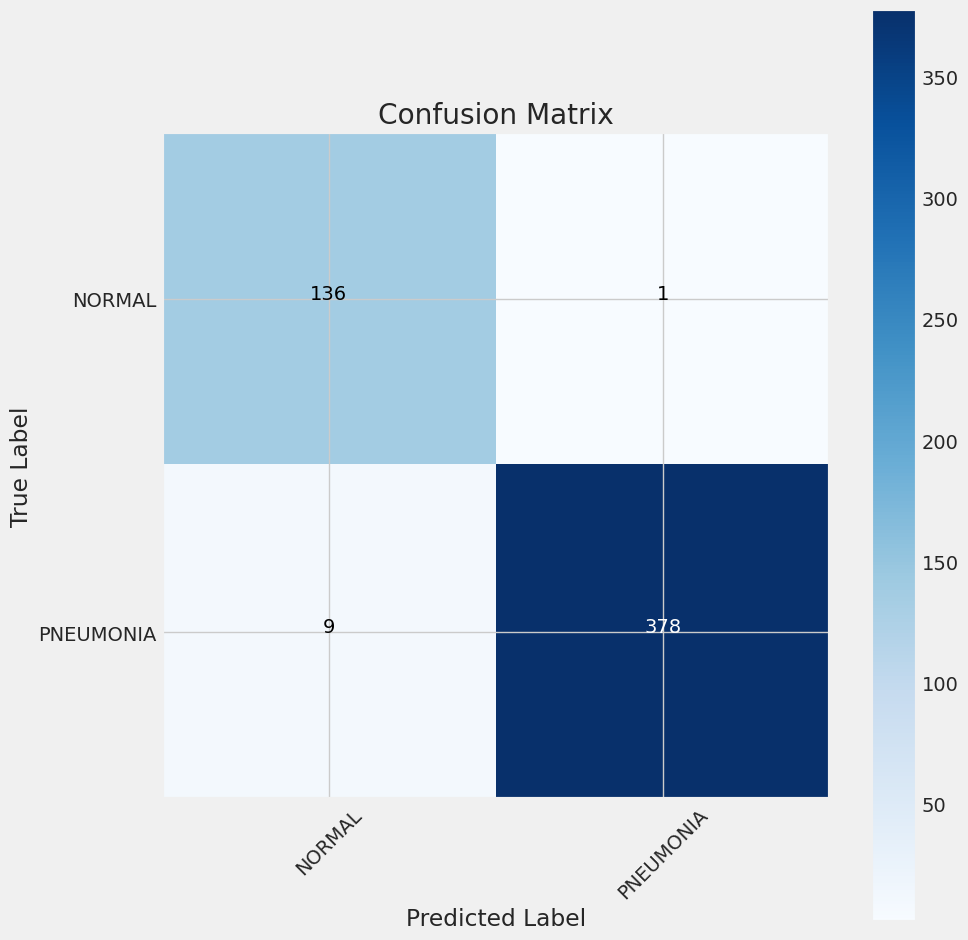

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.94      0.99      0.96       137
   PNEUMONIA       1.00      0.98      0.99       387

    accuracy                           0.98       524
   macro avg       0.97      0.98      0.98       524
weighted avg       0.98      0.98      0.98       524



In [ ]:
%pip install keras-squeezenet
%pip install efficientnet


  Preparing metadata (setup.py) ... done
  Created wheel for keras-squeezenet: filename=keras_squeezenet-0.4-py3-none-any.whl size=3567 sha256=032df653c26bdcc0dfe2109faacf3b2973bb5df7afb7ac56359aaf5ea2e43efc
  Stored in directory: /root/.cache/pip/wheels/f1/d0/32/6d82b57a8253f794375a32359dd2f9ee02a6089cad2222bd78
Successfully built keras-squeezenet
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00


EfficientNet

In [ ]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = EfficientNetB0(input_shape=img_shape, include_top=False, weights='imagenet')

# Freeze the layers in the pre-trained MobileNet model
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i+1}")
    layer.trainable = False

# Add your own classification layers on top of MobileNet
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(class_count, activation='softmax')(x)

# Create a new model combining MobileNet and your classification layers
model = Model(inputs=base_model.input, outputs=output)

model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 15
Layer 16
Layer 17
Layer 18
Layer 19
Layer 20
Layer 21
Layer 22
Layer 23
Layer 24
Layer 25
Layer 26
Layer 27
Layer 28
Layer 29
Layer 30
Layer 31
Layer 32
Layer 33
Layer 34
Layer 35
Layer 36
Layer 37
Layer 38
Layer 39
Layer 40
Layer 41
Layer 42
Layer 43
Layer 44
Layer 45
Layer 46
Layer 47
Layer 48
Layer 49
Layer 50
Layer 51
Layer 52
Layer 53
Layer 54
Layer 55
Layer 56
Layer 57
Layer 58
Layer 59
Layer 60
Layer 61
Layer 62
Layer 63
Layer 64
Layer 65
Layer 66
Layer 67
Layer 68
Layer 69
Layer 70
Layer 71
Layer 72
Layer 73
Layer 74
Layer 75
Layer 76
Layer 77
Layer 78
Layer 79
Layer 80
Layer 81
Layer 82
Layer 83
Layer 84
Layer 85
Layer 86
Layer 87
Layer 88
Layer 89
Layer 90
Layer 91
Layer 92
Layer 93
Layer 94
Layer 95
Layer 96
Layer 97
Layer 98
Layer 99
Layer 100
Layer 101
Layer 102
Layer 103
Layer 104
Lay

In [ ]:
epochs = 13   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/13
262/262 [==============================] - 1959s 7s/step - loss: 0.1121 - accuracy: 0.9548 - val_loss: 0.0738 - val_accuracy: 0.9713
Epoch 2/13
262/262 [==============================] - 61s 232ms/step - loss: 0.0453 - accuracy: 0.9847 - val_loss: 0.0638 - val_accuracy: 0.9828
Epoch 3/13
262/262 [==============================] - 62s 235ms/step - loss: 0.0258 - accuracy: 0.9914 - val_loss: 0.0798 - val_accuracy: 0.9751
Epoch 4/13
262/262 [==============================] - 64s 243ms/step - loss: 0.0267 - accuracy: 0.9909 - val_loss: 0.1313 - val_accuracy: 0.9656
Epoch 5/13
262/262 [==============================] - 61s 235ms/step - loss: 0.0175 - accuracy: 0.9933 - val_loss: 0.0983 - val_accuracy: 0.9713
Epoch 6/13
262/262 [==============================] - 65s 247ms/step - loss: 0.0117 - accuracy: 0.9964 - val_loss: 0.0739 - val_accuracy: 0.9790
Epoch 7/13
262/262 [==============================] - 61s 234ms/step - loss: 0.0105 - accuracy: 0.9967 - val_loss: 0.0691 - val_acc

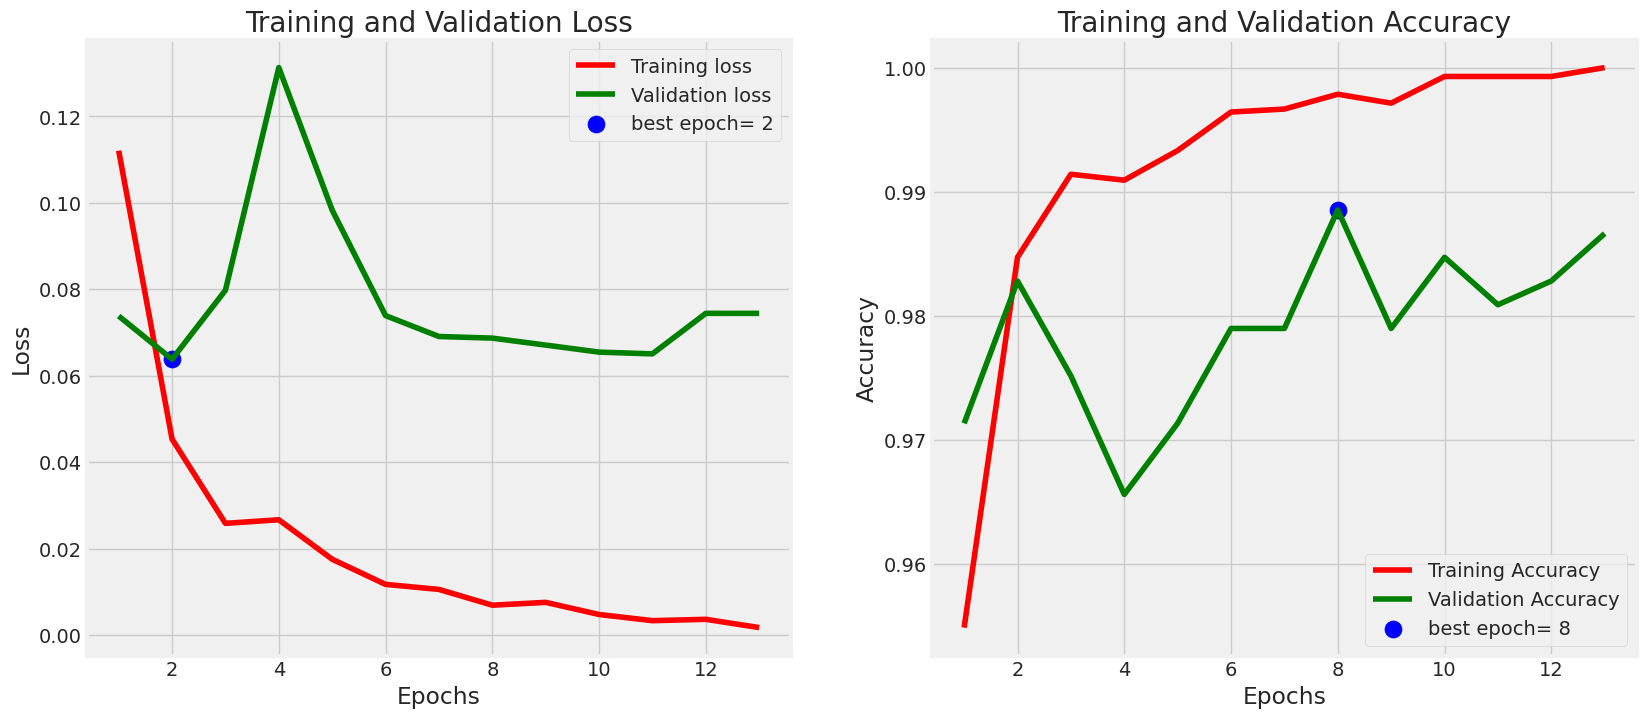

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

33/33 [==============================] - 218s 7s/step - loss: 0.0153 - accuracy: 0.9924
Train Loss:  0.0006393190706148744
Train Accuracy:  1.0
--------------------
Validation Loss:  0.07441259920597076
Validation Accuracy:  0.9866156578063965
--------------------
Test Loss:  0.015261811204254627
Test Accuracy:  0.9923664331436157


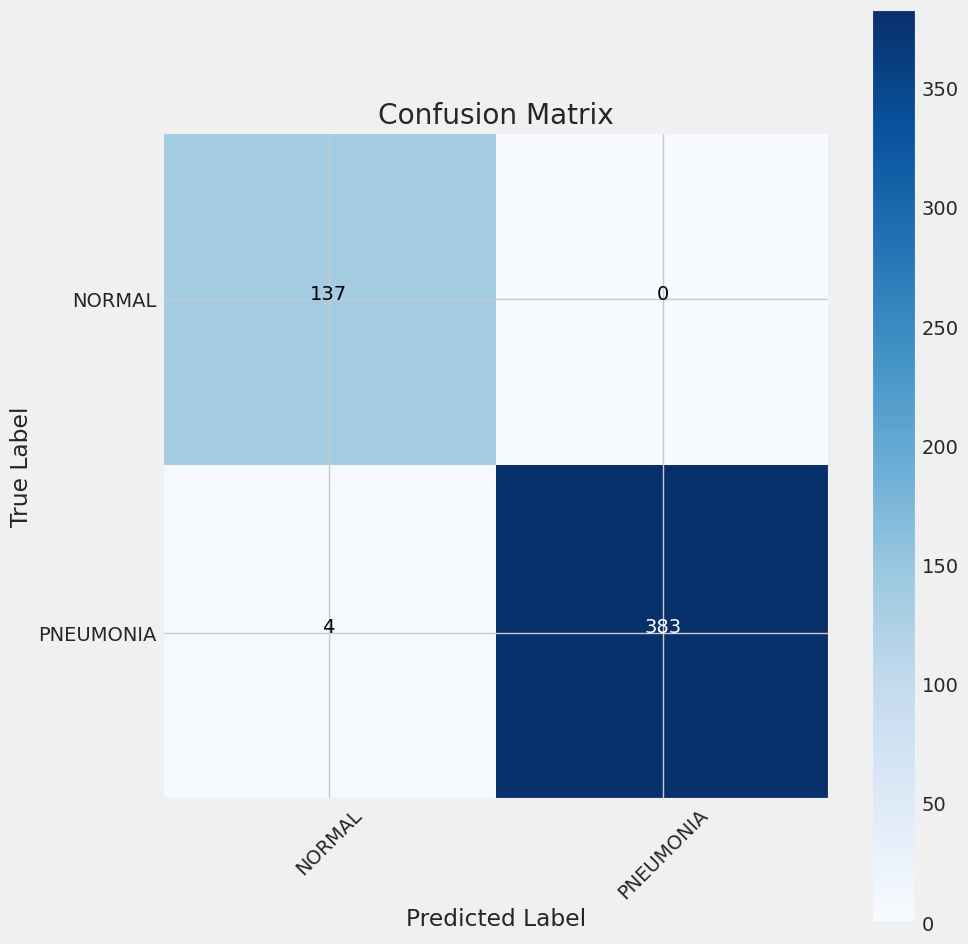

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

SqueezeNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def SqueezeNet(input_shape=(224, 224, 3), classes=1000):
    input_img = Input(shape=input_shape)

    # Initial convolution layer
    x = Convolution2D(96, (7, 7), strides=(2, 2), padding='valid', activation='relu', name='conv1')(input_img)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Fire modules
    def fire_module(x, fire_id, squeeze=16, expand=64):
        s_id = 'fire' + str(fire_id) + '/'
        x = Convolution2D(squeeze, (1, 1), padding='valid', activation='relu', name=s_id + 'squeeze1x1')(x)
        left = Convolution2D(expand, (1, 1), padding='valid', activation='relu', name=s_id + 'expand1x1')(x)
        right = Convolution2D(expand, (3, 3), padding='same', activation='relu', name=s_id + 'expand3x3')(x)
        x = concatenate([left, right], axis=3, name=s_id + 'concat')
        return x

    x = fire_module(x, fire_id=2)
    x = fire_module(x, fire_id=3)
    x = fire_module(x, fire_id=4)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, fire_id=5)
    x = fire_module(x, fire_id=6)
    x = fire_module(x, fire_id=7)
    x = fire_module(x, fire_id=8)
    x = Dropout(0.5, name='drop9')(x)

    # Final layers
    x = Convolution2D(classes, (1, 1), padding='valid', activation='relu', name='conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='softmax')(x)

    model = Model(input_img, x, name='squeezenet')
    return model

In [ ]:
# from keras_squeezenet import SqueezeNet
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = SqueezeNet(input_shape=img_shape)

for i, layer in enumerate(base_model.layers):
    print(f"Layer {i+1}")
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 15
Layer 16
Layer 17
Layer 18
Layer 19
Layer 20
Layer 21
Layer 22
Layer 23
Layer 24
Layer 25
Layer 26
Layer 27
Layer 28
Layer 29
Layer 30
Layer 31
Layer 32
Layer 33
Layer 34
Layer 35
Layer 36
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 109, 109, 96)         14208     ['input_2[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 54, 54, 96)           0         ['conv

In [ ]:
%pip install keras

In [ ]:
epochs = 13   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/13
262/262 [==============================] - 61s 228ms/step - loss: 0.6482 - accuracy: 0.7480 - val_loss: 0.6196 - val_accuracy: 0.7170
Epoch 2/13
262/262 [==============================] - 58s 220ms/step - loss: 0.5811 - accuracy: 0.7480 - val_loss: 0.5959 - val_accuracy: 0.7170
Epoch 3/13
262/262 [==============================] - 59s 224ms/step - loss: 0.5657 - accuracy: 0.7480 - val_loss: 0.5975 - val_accuracy: 0.7170
Epoch 4/13
262/262 [==============================] - 60s 229ms/step - loss: 0.5647 - accuracy: 0.7480 - val_loss: 0.5985 - val_accuracy: 0.7170
Epoch 5/13
262/262 [==============================] - 59s 227ms/step - loss: 0.5647 - accuracy: 0.7480 - val_loss: 0.5982 - val_accuracy: 0.7170
Epoch 6/13
262/262 [==============================] - 58s 222ms/step - loss: 0.5647 - accuracy: 0.7480 - val_loss: 0.5977 - val_accuracy: 0.7170
Epoch 7/13
262/262 [==============================] - 58s 220ms/step - loss: 0.5646 - accuracy: 0.7480 - val_loss: 0.5977 - val_ac

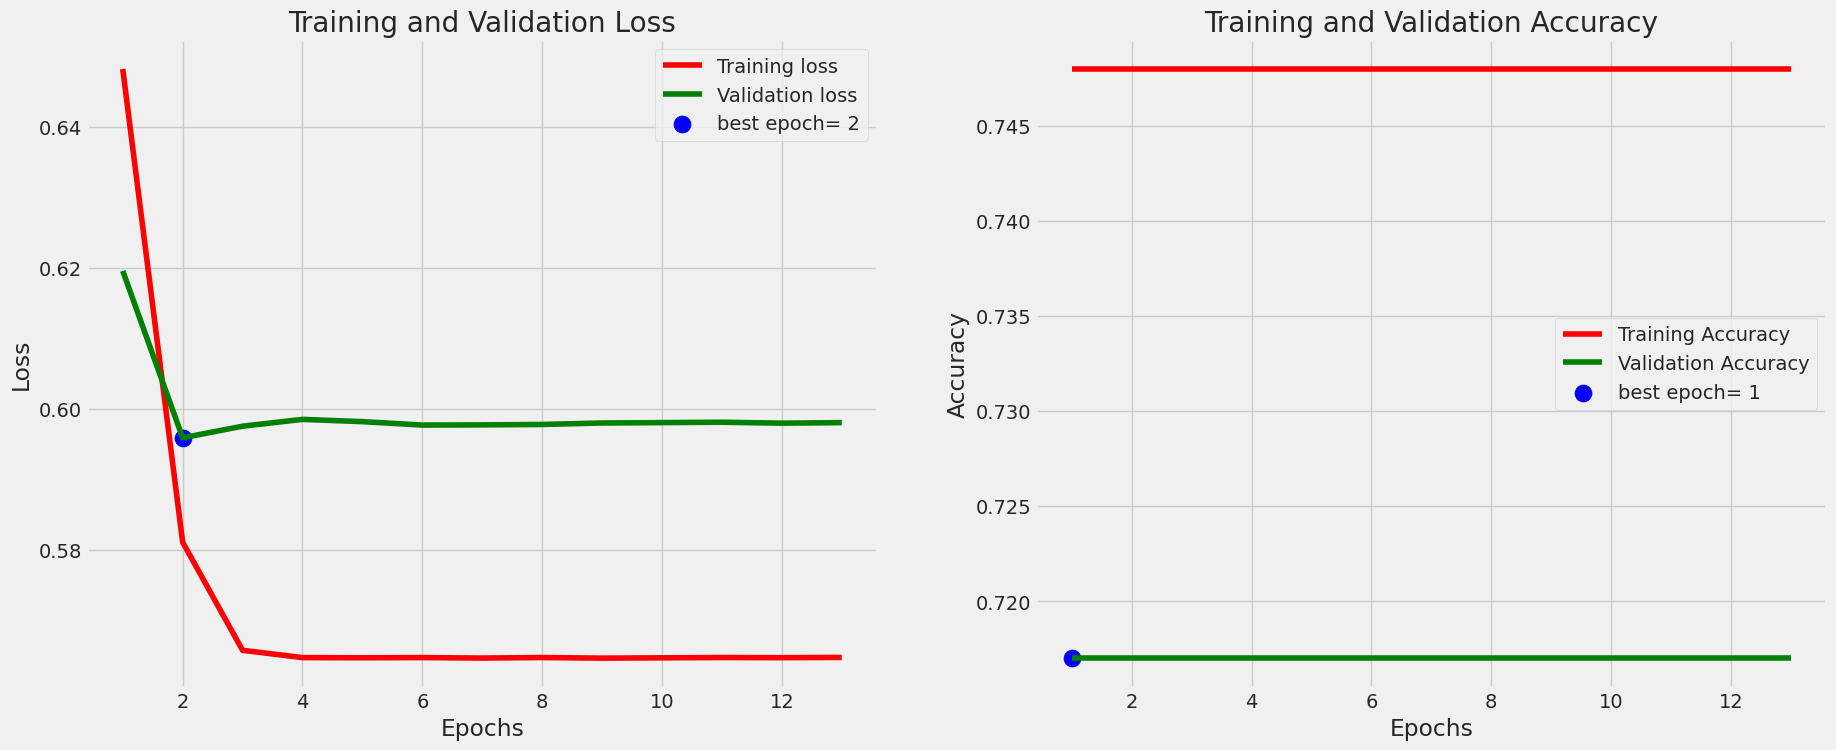

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

33/33 [==============================] - 7s 198ms/step - loss: 0.5747 - accuracy: 0.7385
Train Loss:  0.5645574331283569
Train Accuracy:  0.7479694485664368
--------------------
Validation Loss:  0.5980424284934998
Validation Accuracy:  0.7170172333717346
--------------------
Test Loss:  0.5747480988502502
Test Accuracy:  0.7385495901107788
